# 1.Імпорт і формування вибірки

In [0]:
import os
import PIL.Image
import cv2

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [8]:
def getImgs(path):
  imgs=[] 
  for img in os.listdir(path):
    imgs.append(np.array(PIL.Image.open(path+img)))
    
  return np.asarray(imgs)

imgs= getImgs('/content/drive/My Drive/mirflickr/')
print('Sampled {} RGB-images'.format(len(imgs)))

Sampled 250 RGB-images


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
green_img_list=[]
for img in imgs:
  green_img_list.append(np.array(cv2.split(img)[1]))

green_img_list = np.array(green_img_list)

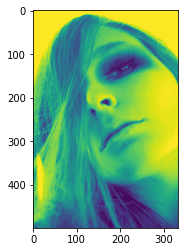

In [11]:
plt.imshow(green_img_list[1])

In [12]:
green_img_list[8].shape

(335, 500)

# 2.Декомпозиція

Для реалізації методу головних компонент застосувала бібліотеку sklearn. у функції нижче створюєтьс об'єкт PCA(), в якому важливим аргументом є n_components, що позначає відсоток або кількість головних компонент, які хочемо отримати (якщо None, тоді з документації n_components == min(n_samples, n_features) - 1, тобто в нашому випадку, декомпозуючи картинку, за кількість компонент вибирається або її ширина, або висота - залежно від того, що менше). Саму ж сингулярну декомпозицію забезпечує метод fit_transform(), який знаходить сингулярні вектори (вони ж - головні компоненти), відповідні їм сингулярні числа, дисперсія значень яскравості пікселів зеленого каналу і т.п. Для реконструкції зображення застосовуєтьс метод inverse_transform.

In [0]:
def decompose_reconstruct(img, reconstruct=False, alpha=None):
  pca = PCA(n_components=alpha, svd_solver='full')
  decomposed_img=pca.fit_transform(img)
  if reconstruct:
    return pca.inverse_transform(decomposed_img)
  return pca

Як приклад, реконструюємо одне із тестових зображень та побудуємо scree plot із першими 10-ма головними компонентами та відсотком дисперсії, яку кожна з них поснює.

In [0]:
pca=decompose_reconstruct(green_img_list[1])
reconstructed_img=decompose_reconstruct(green_img_list[1], reconstruct=True)

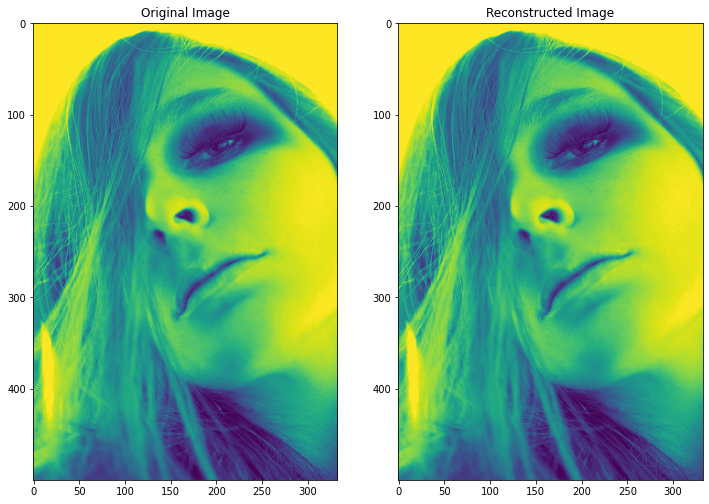

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].imshow(green_img_list[1])
axs[1].imshow(reconstructed_img)
axs[0].title.set_text('Original Image')
axs[1].title.set_text('Reconstructed Image')

Кількість компонент рівна ширині зображення.

In [16]:
len(pca.components_)==green_img_list[1].shape[1]

True

Scree plot

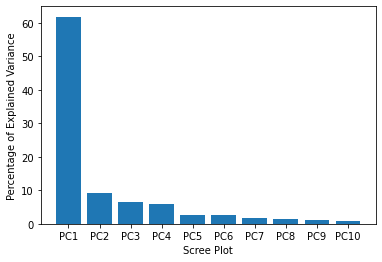

In [17]:
percentage_var=[]
for i in range(10):
  percentage_var.append(np.round(pca.explained_variance_ratio_[i]*100, decimals=1))
plot_labels = ['PC' + str(x) for x in range(1, 11)]
plt.bar(x=range(1, 11), height=percentage_var, tick_label = plot_labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Scree Plot')
plt.show()

a) За замовченням сингулярні числа вже відсортовані в порядку зменшення.

In [18]:
pca.singular_values_

array([1.86795084e+04, 7.23427945e+03, 6.07421458e+03, 5.69902624e+03,
       3.92882819e+03, 3.73736062e+03, 3.03040100e+03, 2.66065436e+03,
       2.53175197e+03, 2.25880294e+03, 1.93142727e+03, 1.75927256e+03,
       1.68484484e+03, 1.54033275e+03, 1.48837479e+03, 1.27626966e+03,
       1.18995560e+03, 1.09810763e+03, 1.03801822e+03, 9.56854388e+02,
       9.42355502e+02, 8.73486022e+02, 8.52160060e+02, 8.26687963e+02,
       7.71076415e+02, 7.25990463e+02, 6.96739586e+02, 6.63473842e+02,
       6.48984379e+02, 6.16493450e+02, 6.12291080e+02, 5.98390387e+02,
       5.67620950e+02, 5.63761744e+02, 5.37795500e+02, 5.21029711e+02,
       5.12356998e+02, 4.95196957e+02, 4.82547019e+02, 4.60417676e+02,
       4.52314084e+02, 4.45829950e+02, 4.30755104e+02, 4.22864762e+02,
       4.17521240e+02, 4.07548087e+02, 4.03954969e+02, 3.94696354e+02,
       3.82451826e+02, 3.69751799e+02, 3.64498495e+02, 3.61003049e+02,
       3.55543838e+02, 3.47200482e+02, 3.42288651e+02, 3.36360911e+02,
      

## Порівняння

In [19]:
mse_1 = mean_squared_error(green_img_list[1], reconstructed_img)
print('MSE={}'.format(mse_1))

MSE=2.3575537728749483e-26


Показник середньоквадратичного відхилення, обрахований вище, зовсім незначний, оскільки для реконструкції було використано всі головні компоненти. Виберемо лише alpha% компонент (10<alpha<100, step=10) і знову порівняємо вихідне та реконструйоване зображення за показником MSE. 

###b) Реконструкція зображенні при використанні alpha% компонентів

In [0]:
def reconstructed_list(img):
  reconstructed_list = [decompose_reconstruct(img, reconstruct=True, alpha=0.1*step) for step in range(1,10)]
  reconstructed_list.append(decompose_reconstruct(img, reconstruct=True))
  return np.array(reconstructed_list)

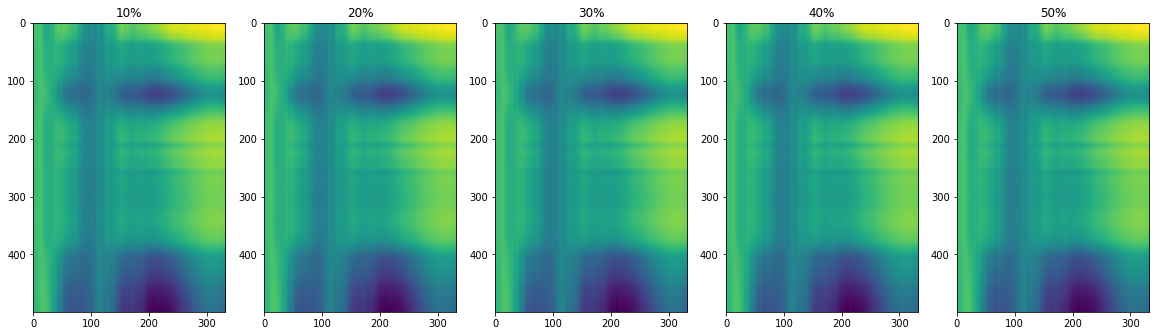

In [21]:
reconstructed_list_1 = reconstructed_list(green_img_list[1])
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(reconstructed_list_1[0])
axs[0].title.set_text('10%')
axs[1].imshow(reconstructed_list_1[1])
axs[1].title.set_text('20%')
axs[2].imshow(reconstructed_list_1[2])
axs[2].title.set_text('30%')
axs[3].imshow(reconstructed_list_1[3])
axs[3].title.set_text('40%')
axs[4].imshow(reconstructed_list_1[4])
axs[4].title.set_text('50%')

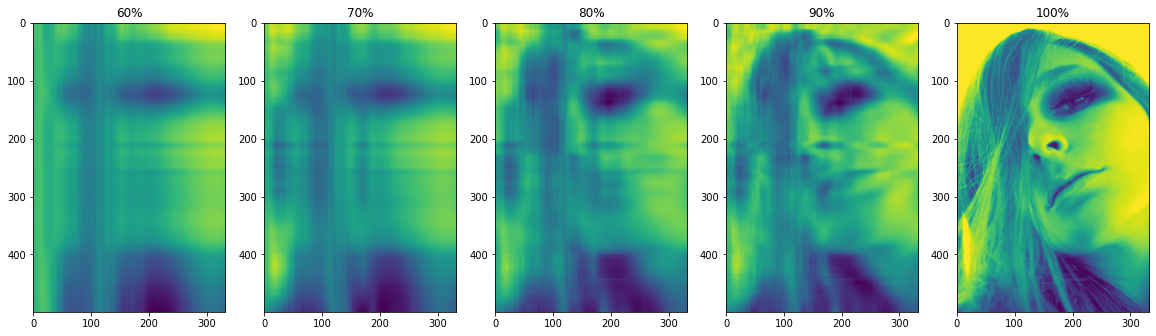

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(reconstructed_list_1[5])
axs[0].title.set_text('60%')
axs[1].imshow(reconstructed_list_1[6])
axs[1].title.set_text('70%')
axs[2].imshow(reconstructed_list_1[7])
axs[2].title.set_text('80%')
axs[3].imshow(reconstructed_list_1[8])
axs[3].title.set_text('90%')
axs[4].imshow(reconstructed_list_1[9])
axs[4].title.set_text('100%')

###c) Порівняння вихідного та реконструйованих зображень (MSE)

Функція нижче повертає масив із середньоквадратичних відхилень реконструйованого зображення від вихідного для кожного alpha (10-100%).

In [0]:
def compareImgs(original, images):
  mse_list = np.array([mean_squared_error(original, recon_img) for recon_img in images])
  return mse_list

In [0]:
alphas = [10*step for step in range(1, 11)]

In [0]:
mse_list = compareImgs(green_img_list[1], reconstructed_list_1)

In [26]:
df = pd.DataFrame(data=mse_list, columns=['MSE'], index=["{}{}".format(a, '%') for a in alphas])
df.T

,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
MSE,1293.923051,1293.923051,1293.923051,1293.923051,1293.923051,1293.923051,979.599934,562.93337,331.180304,2.357554e-26


Графік залежності значення середньоквадратичного відхилення від частки головних компонент, що була використана для реконструкції зображення.

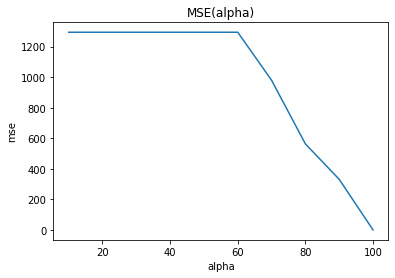

In [27]:
plt.plot(alphas, mse_list)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('MSE(alpha)')
plt.show()

###d) Усереднині MSE(alpha) по тестовому пакету

In [0]:
def mean_mse(original_imgs, rcnstrctd_imgs):
  mean_mse = [np.mean([mean_squared_error(original_imgs[idx], rcnstrctd_imgs[alpha][idx]) for idx in range(len(original_imgs))]) for alpha in range(10)]
  return mean_mse

In [0]:
rcnstrctd_list_alphas = [[decompose_reconstruct(img, reconstruct=True, alpha=0.1*step) for img in green_img_list] for step in range(1,10)]
rcnstrctd_list_alphas.append([decompose_reconstruct(img, reconstruct=True) for img in green_img_list])
rcnstrctd_list_alphas = np.array(rcnstrctd_list_alphas)

In [0]:
mean_mse = mean_mse(green_img_list, rcnstrctd_list_alphas)

In [31]:
df = pd.DataFrame(data=mean_mse, columns=['Mean MSE'], index=["{}{}".format(a, '%') for a in alphas])
df.T

,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
Mean MSE,1688.667444,1670.686122,1595.455309,1447.142376,1241.382283,1051.95345,829.148276,588.359894,306.701244,4.985369e-26


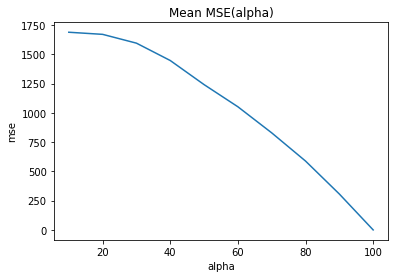

In [32]:
plt.plot(alphas, mean_mse)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Mean MSE(alpha)')
plt.show()

# Моделювання марківськими ланцюгами

##a) Формування стохастичної матриці

Всього станів у марківському ланцюзі 256 (кожний відповідає за значення яскравості пікселя), тому утворена матриця має розмір (256, 256) і містить імовірності переходу від одного стану до іншого. До нормалізації матриця формувалася обробкою значень яскравості пікселів методом 1 (по горизонталі, зліва направо). 

In [0]:
def left_to_right_iteration(img, matrix):
  for row in range(img.shape[0]):
    for col in range(img.shape[1]-1):
      from_idx, to_idx = img[row][col], img[row][col+1]
      matrix[from_idx][to_idx]+=1

#https://stackoverflow.com/questions/8904694/how-to-normalize-a-2-dimensional-numpy-array-in-python-less-verbose
def normalize(matrix):
  row_sums = matrix.sum(axis=1) #сумуємо вздовж рядка по значеннях у стовпцях; на виході - масив із сумами кожного рядка
  return matrix/row_sums[:, np.newaxis] #row_sums.shape=(256,) -> row_sums.shape = (256, 1): для коректного ділення матриці на масив

def stochastic_matrix(images):
  st_mtrx = np.zeros((256, 256))
  for img in images:
    left_to_right_iteration(img, st_mtrx)
  st_mtrx = normalize(st_mtrx)
  return st_mtrx

In [34]:
Q = stochastic_matrix(green_img_list)
Q.shape

(256, 256)

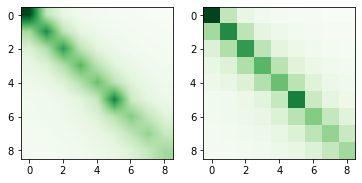

In [57]:
import matplotlib.cm as cm
fig = plt.figure()
ax1 = fig.add_subplot(121)
# білінійна інтерполяція - виглядатиме розмито
ax1.imshow(Q[1:10,1:10], interpolation='bilinear', cmap=cm.Greens)

ax2 = fig.add_subplot(122)
# 'найближча' інтерполяція - правдива, але блоками
ax2.imshow(Q[1:10,1:10], interpolation='nearest', cmap=cm.Greens)

plt.show()

In [53]:
newQ = numpy.linalg.matrix_power(Q, 5)
if ((newQ <= 0).sum() == 0):    #regularity check
  print('Matrix is regular.')
else:
  print('Matrix is not regular.')

def recurrence_check(matrix):    #recurrence check
    for i in range(matrix.shape[0]):
        if matrix[i, i] == 0:
            return False
    return True   

if recurrence_check(newQ):
  print('Marix is recurrent.')
else:  
  print('Marix is not recurrent.')

Matrix is regular.
Marix is recurrent.
